# Модели TensorFlow

In [249]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
import IPython
import IPython.display
import matplotlib as mpl
import seaborn as sns
import tensorflow as tf

In [250]:
energo = pd.read_csv('result.csv')

## Почасовой прогноз

In [251]:
df = energo[['Генерация, МВт*ч\\', 'Потребление, МВт*ч', 'T', 'Po', 'U', 'Ff', 'VV']]

column_indices = {name: i for i, name in enumerate(df.columns)}
n = len(df)
num_features = df.shape[1]
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

#### Параметры
+ T - Температура
+ Po - Атмосферное давление
+ U - Обносительная влажность
+ Ff - скорость ветра
+ VV - Горизонтальная дальность видимости

In [252]:
df.head(1)

,"Генерация, МВт*ч\","Потребление, МВт*ч",T,Po,U,Ff,VV
0,24804,25605,-23.6,751.0,84.0,1.0,4.0


In [253]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [254]:
len(train_df), len(val_df), len(test_df)

(4872, 1392, 697)

In [255]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def plot(self, model=None, plot_col='Потребление, МВт*ч', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')
        
    def get(self, model, plot_col='Потребление, МВт*ч'):
        inputs, labels = self.example
        plot_col_index = self.column_indices[plot_col]
        max_n = min(3, len(inputs))
        
        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index
        return model(inputs)[max_n-1, :, label_col_index]
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

        ds = ds.map(self.split_window)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result

In [256]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [257]:
OUT_STEPS = 24*7
multi_window = WindowGenerator(input_width=24*7*3,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

# multi_window.plot()
# multi_window

In [258]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

# multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
# multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
# multi_window.plot(last_baseline)

In [259]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

# multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
# multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
# multi_window.plot(repeat_baseline)

#### Linear

In [260]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

23/23 [==============================] - 0s 2ms/step - loss: 0.5111 - mean_absolute_error: 0.5378


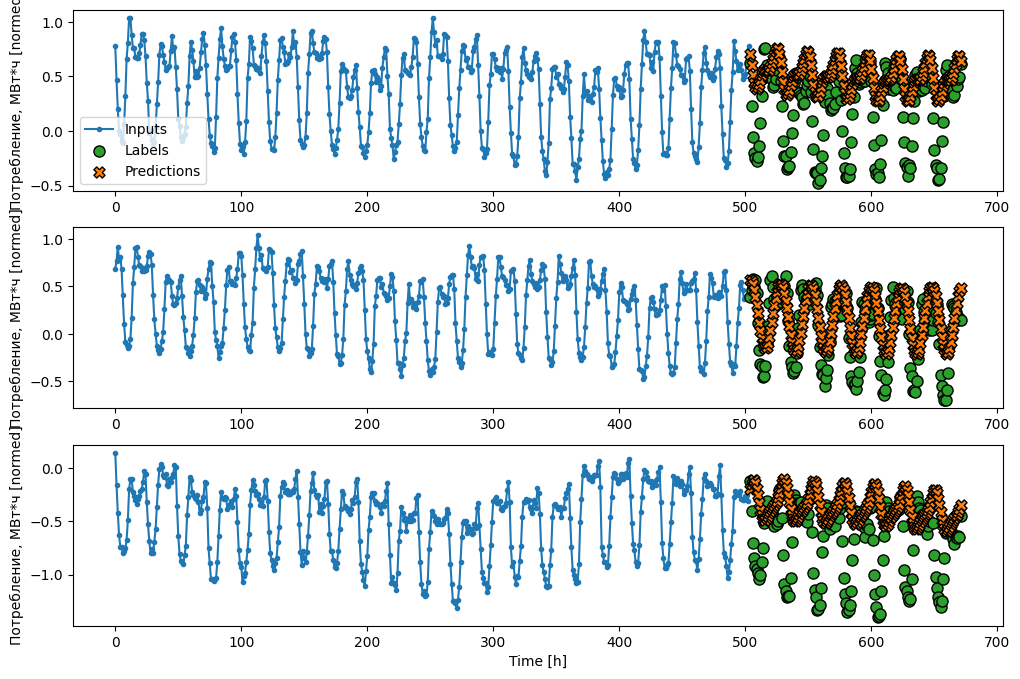

In [261]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### Dense

23/23 [==============================] - 0s 4ms/step - loss: 0.4554 - mean_absolute_error: 0.5141


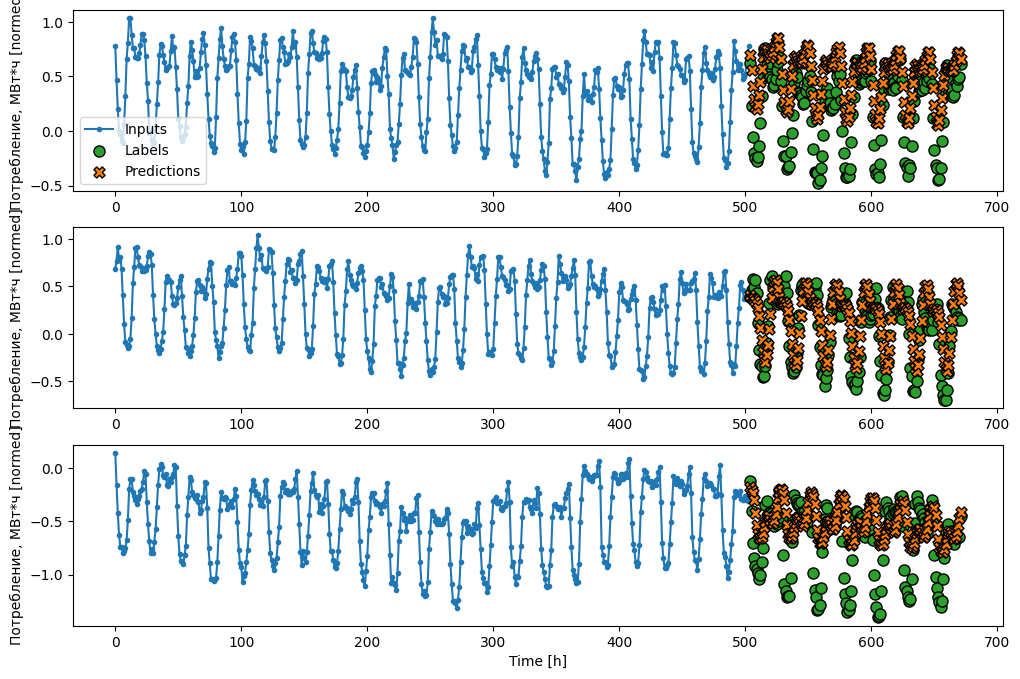

In [262]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

23/23 [==============================] - 0s 3ms/step - loss: 0.4115 - mean_absolute_error: 0.4756


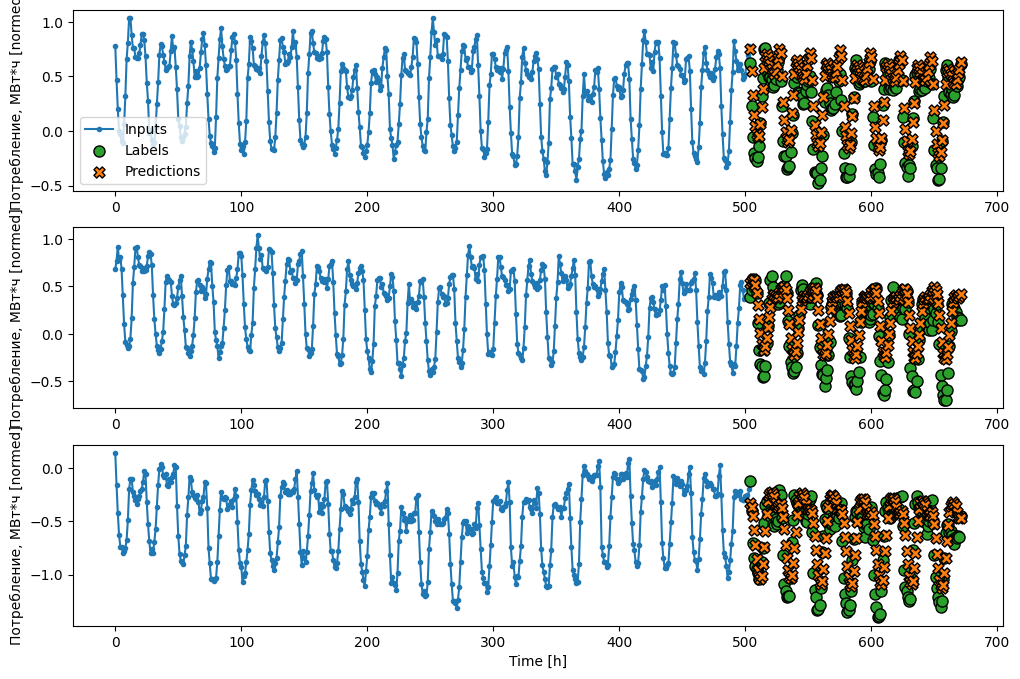

In [263]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN

23/23 [==============================] - 1s 42ms/step - loss: 0.3975 - mean_absolute_error: 0.4870


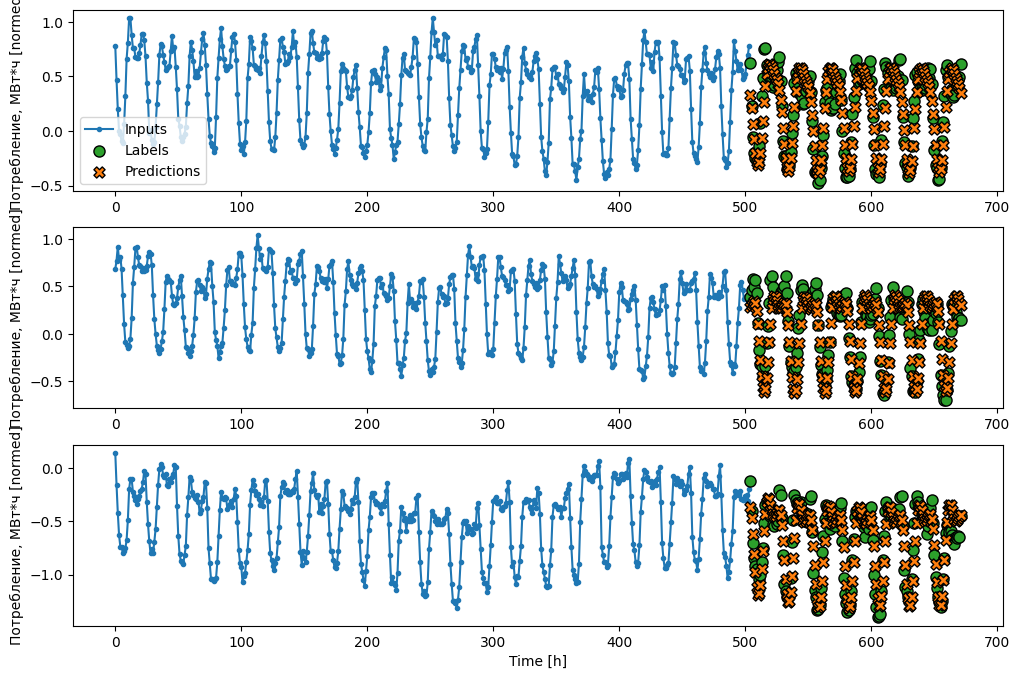

In [264]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

#### Сравнение

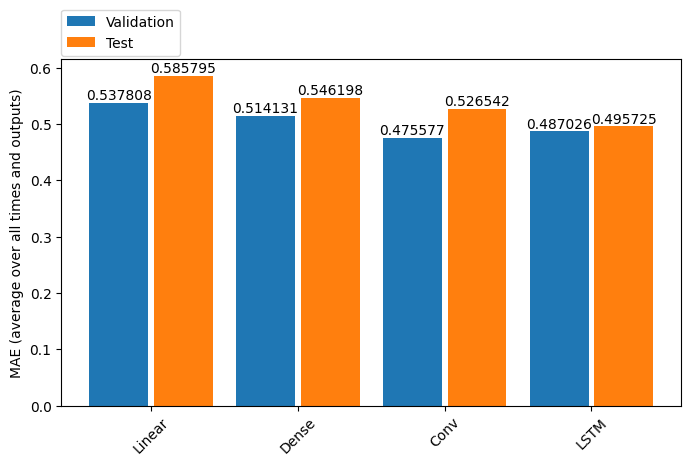

In [265]:
x = np.arange(len(multi_performance))
width = 0.4

metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.figure(figsize=(8, 4.5))
bar1 = plt.bar(x - 0.22, val_mae, width, label='Validation')
bar2 = plt.bar(x + 0.22, test_mae, width, label='Test')
plt.bar_label(bar1)
plt.bar_label(bar2)
plt.xticks(ticks=x, labels=multi_performance.keys(), rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend(loc=(0, 1.01))

## Посуточный прогноз

In [206]:
labels = ['Генерация, МВт*ч\\', 'Потребление, МВт*ч', 'T', 'Po', 'U', 'Ff', 'VV']

In [207]:
days = len(energo['Потребление, МВт*ч'])
hours = days // 24

In [208]:
d = {i: [j.mean() for j in np.array(energo[i])[:24*hours].reshape((hours, 24))] for i in labels}

In [209]:
df = pd.DataFrame(d)

In [210]:
column_indices = {name: i for i, name in enumerate(df.columns)}
n = len(df)
num_features = df.shape[1]
train_df = df[0:int(n*0.5)]
val_df = df[int(n*0.5):int(n*0.8)]
test_df = df[int(n*0.8):]

In [211]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [212]:
len(train_df), len(val_df), len(test_df)

(145, 87, 58)

In [213]:
OUT_STEPS = 20
multi_window = WindowGenerator(input_width=30,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

# multi_window.plot()
# multi_window

In [214]:
last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

# multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
# multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
# multi_window.plot(last_baseline)

In [215]:
repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

# multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
# multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
# multi_window.plot(repeat_baseline)

#### Linear

In [216]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

42/42 [==============================] - 0s 2ms/step - loss: 0.3876 - mean_absolute_error: 0.4538


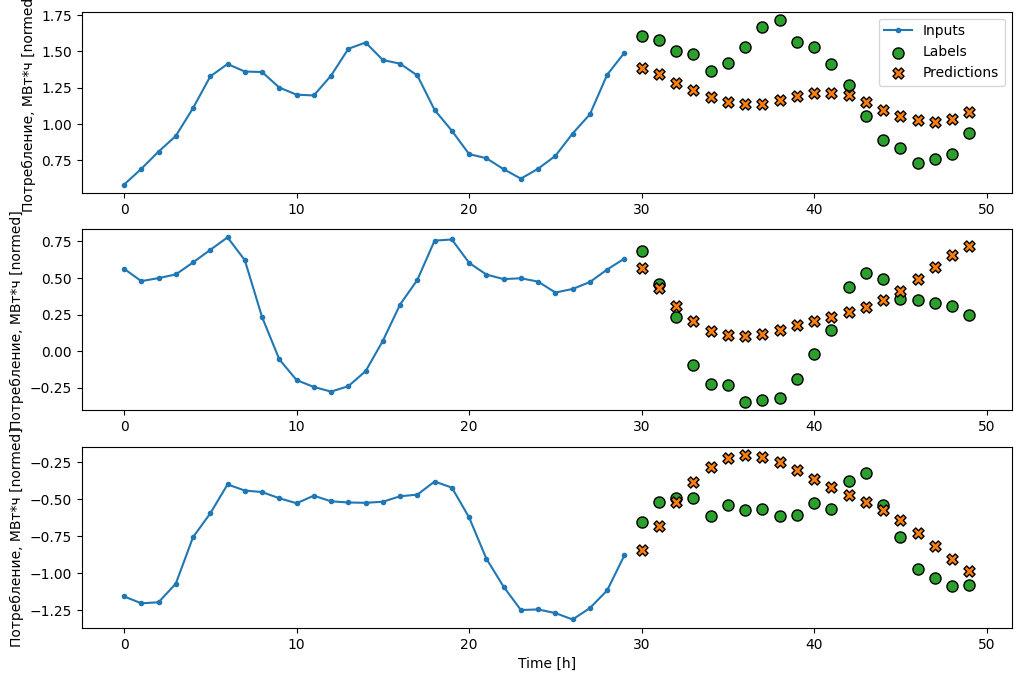

In [217]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### Dense

42/42 [==============================] - 0s 2ms/step - loss: 0.3484 - mean_absolute_error: 0.4319


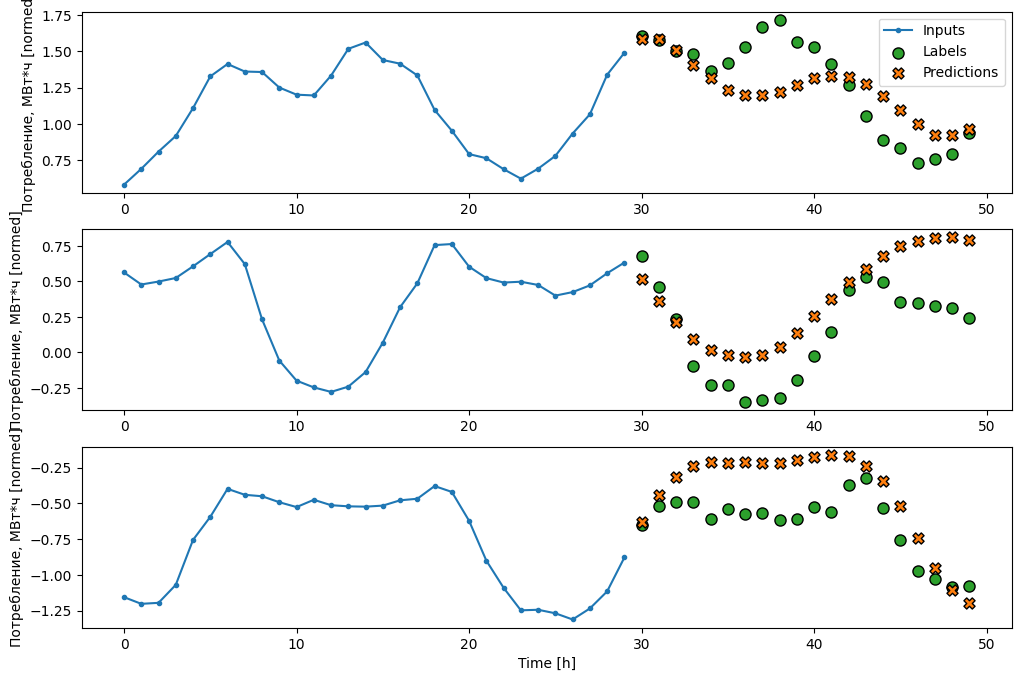

In [218]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

42/42 [==============================] - 0s 2ms/step - loss: 0.3116 - mean_absolute_error: 0.4049


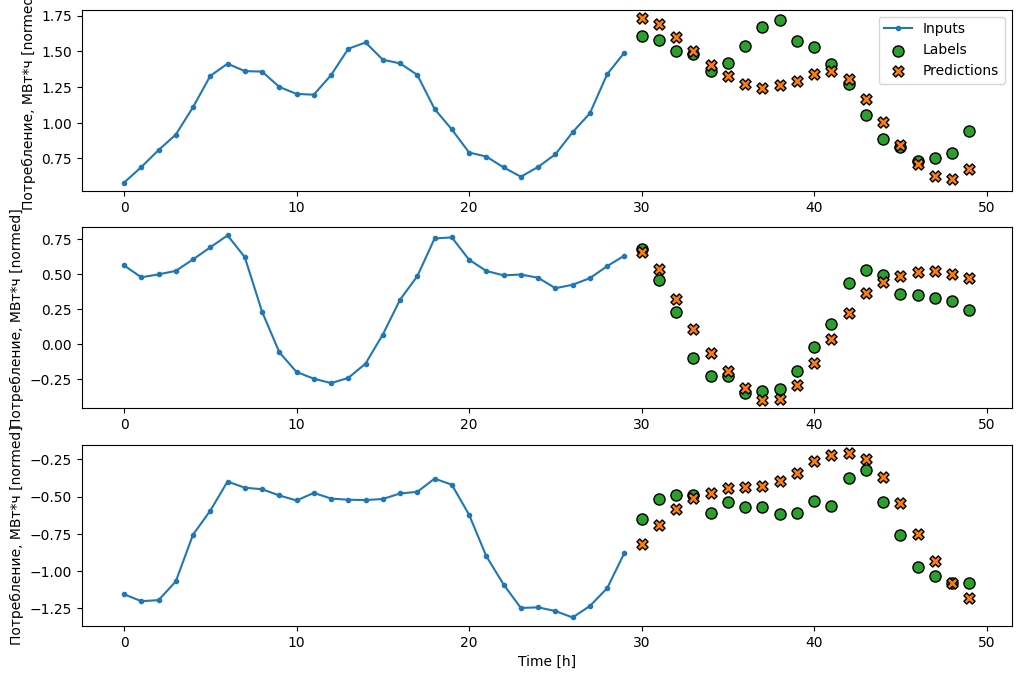

In [219]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN

42/42 [==============================] - 0s 4ms/step - loss: 0.2696 - mean_absolute_error: 0.3704


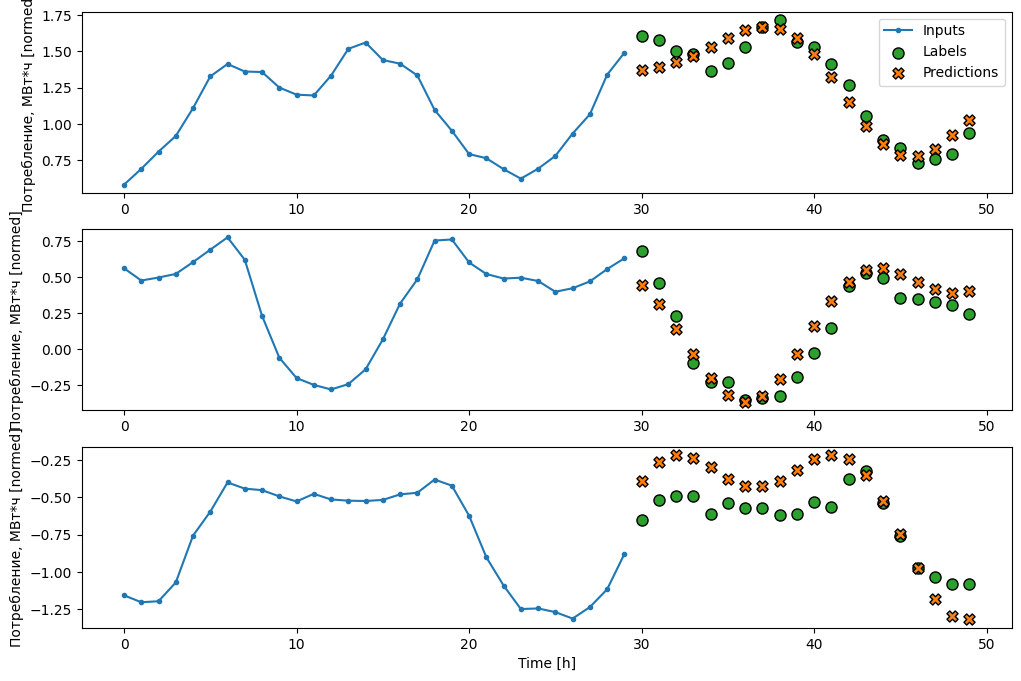

In [220]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

#### Сравнение

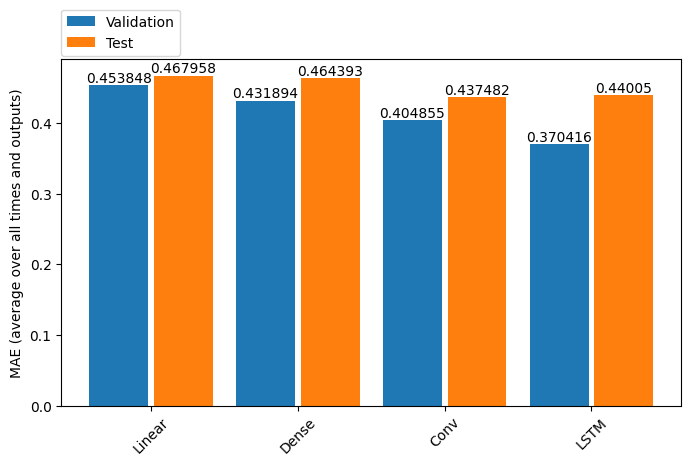

In [248]:
x = np.arange(len(multi_performance))
width = 0.4

metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.figure(figsize=(8, 4.5))
bar1 = plt.bar(x - 0.22, val_mae, width, label='Validation')
bar2 = plt.bar(x + 0.22, test_mae, width, label='Test')
plt.bar_label(bar1)
plt.bar_label(bar2)
plt.xticks(ticks=x, labels=multi_performance.keys(), rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend(loc=(0, 1.01))